# Capacitance Model and Charge-Stability Diagrams

This notebook deals with the simulation of a bare bones capacitance model for a N dot system. The capacitances are set before the simulation and are not calculated from an underlying theory.

The basic goal of this notebook is to produce a honeycomb diagram for a double dot system.



Calculation finished in 405.64307713508606 seconds.


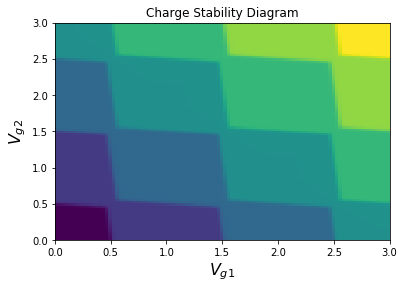

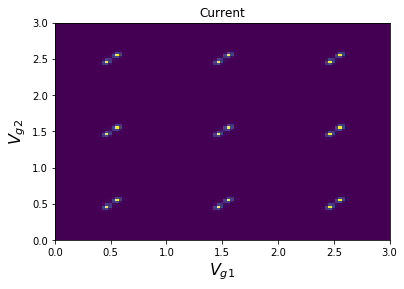

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

# Number of dots in the system
N_dot = 2

# define the capacitances
# the dot capacitance, assumed to be equal for all dots
C_dot = 1
# inter-dot cross capacitance, assumed to be equal for all dots
C_dot_cross = -0.1

# gate capacitance, assumed to equal for all gates
C_g = 1.0
C_g_cross = 0


# The dots are assumed to be in a linear geometry. Hence, the cross capacitance acts only between adjacent dots.
def calc_cap_matrix(N_dot,C_diag,C_cross):
    C_mat = np.diag(C_diag*np.ones(N_dot),k = 0) + \
            np.diag(C_cross*np.ones(N_dot-1),k = 1) + \
            np.diag(C_cross*np.ones(N_dot-1),k = -1) 
    return C_mat

C_mat_dot = calc_cap_matrix(N_dot,C_dot,C_dot_cross)
C_mat_gate = calc_cap_matrix(N_dot,C_g,C_g_cross)

# left to right tunnel rate, assumed to be same for both leads
t_LR = 1.1
# interdot tunnel rate, assumed to be same and equal in both directions
t_in = 1.0
# right to left tunnel rate, assumed to same for both leads
t_RL = 1.0

t_vec = np.array([t_LR,t_in,t_RL])

def calc_U(N_vec,V_g_vec,C_mat_dot,C_mat_gate): 
    # -1.0 because electron charge is negative
    Q_vec = -1.0 * N_vec + np.dot(C_mat_gate,V_g_vec) 
    
    # We solve the linear system Q = C V, where V contains the unknown electrochemical potentials U
    U_vec = np.linalg.solve(C_mat_dot,Q_vec)
    
    U = 0.5 * np.dot(U_vec,np.dot(C_mat_dot,U_vec.T))
    return U

def fermi(E,kT):
    from scipy.special import expit
    return expit(-E/kT) 

def calc_weight(a,b,V_g_vec,C_mat_dot,C_mat_gate,t_vec,kT):
    N_dot = len(a)
    
    def neigh(a):
        i = a[0]
        j = a[1]
        n = [[i+1,j],[i-1,j],[i-1,j+1],[i+1,j-1],[i,j+1],[i,j-1]]
        return n
    if list(b) in neigh(a):
        U_a = calc_U(np.array(a),V_g_vec,C_mat_dot,C_mat_gate)
        U_b = calc_U(np.array(b),V_g_vec,C_mat_dot,C_mat_gate)
        # notice the order, calc_weight calculates the weight to go from a to b
       
        diff = list(np.array(a) - np.array(b))
        if diff == [-1,0]:
            t = t_vec[0]
        elif diff == [0,1]:
            t = t_vec[0] 
        elif diff == [1,0]:
            t = t_vec[2] 
        elif diff == [0,-1]:
            t = t_vec[2] 
        else:
            t = t_vec[1] 
        return t*fermi(U_b - U_a,kT)
    else:
        return 0.0

def calc_charge(N_dot,V_g_vec,C_mat_dot,C_mat_gate,kT):
   
    E_max = 6
    # create the array with all possible electronic states on dots
    states = list(itertools.product(*[list(range(E_max))]*N_dot)) 
    
    # A : adjacency matrix between the possible states, two states are connected only by a single electron tunneling event
    A = np.array([calc_weight(a,b,V_g_vec,C_mat_dot,C_mat_gate,t_vec,kT) for a in states for b in states])\
        .reshape((len(states),len(states)))

    M = A.T - np.diag(np.sum(A,axis=1))
    
    # append the normalisation condition, and drop ones of the rows of M
    M_solver = np.append(M[:-1,:],[np.ones(M.shape[0])]).reshape(M.shape)

    # RHS in the master equation solution, the last element is the prob. normalisation condition
    b = np.zeros(M.shape[0])
    b[-1] = 1
    P = np.linalg.solve(M_solver,b)
    #state = states[np.argmax(P)]
    
    state = np.sum(np.array([x*np.array(y) for (x,y) in zip(P,states)]),axis=0)
   
    current = 0
    for x in states:
        for y in states:
            if list(np.array(x) - np.array(y)) == [-1,0]:
                index_x = states.index(x)
                index_y = states.index(y)
                current += P[index_x] * A[index_x,index_y] 
            elif list(np.array(x) - np.array(y)) == [1,0]:
                index_x = states.index(x)
                index_y = states.index(y)
                current += -1.0*P[index_x] * A[index_x,index_y] 
            else:
                current += 0.0
    return state,current

kT = 1e-2
N_v = 100
V_g_vec = np.linspace(0,3,N_v)
V_g_arr = list(itertools.product(*[list(V_g_vec)]*N_dot))

import time
st = time.time()
charge = [calc_charge(N_dot,x,C_mat_dot,C_mat_gate,kT) for x in V_g_arr]
print("Calculation finished in",time.time()-st,"seconds.")

# specific to 2 dot
XX,YY = np.meshgrid(V_g_vec,V_g_vec)
plt.figure(1)
plt.pcolor(XX,YY,np.array([np.sum(x[0]) for x in charge]).reshape(N_v,N_v))
plt.xlabel(r"$V_{g1}$",fontsize=16)
plt.ylabel(r"$V_{g2}$",fontsize=16)
plt.title("Charge Stability Diagram")
plt.figure(2)
plt.pcolor(XX,YY,np.array([np.sum(x[1]) for x in charge]).reshape(N_v,N_v))
plt.xlabel(r"$V_{g1}$",fontsize=16)
plt.ylabel(r"$V_{g2}$",fontsize=16)
plt.title("Current")

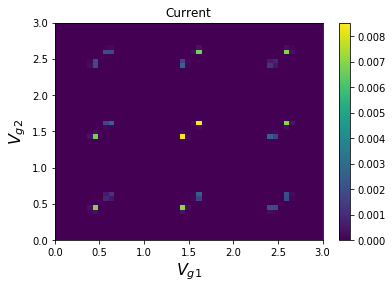

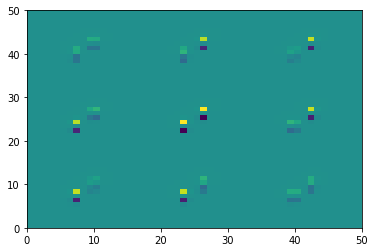

In [24]:
curr_mat = np.array([np.sum(x[1]) for x in charge]).reshape(N_v,N_v)
plt.figure(1)
plt.pcolor(XX,YY,np.abs(np.array([np.sum(x[1]) for x in charge])).reshape(N_v,N_v))
plt.xlabel(r"$V_{g1}$",fontsize=16)
plt.ylabel(r"$V_{g2}$",fontsize=16)
plt.title("Current")
plt.colorbar()


plt.figure(2)
plt.pcolor(np.gradient(curr_mat)[0])

In [ ]:
np.gradient(curr_mat)

In [ ]:
curr_mat

In [ ]:
curr_mat.shape


In [9]:
curr_mat.max()

1.3727347239147406e-15